## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Minimisation des modèles à mettre dans le _pandas_

In [41]:
gen = stretchevol.generic()
gen.set_model('Evol1G1M2S')

gen.set_data(df[df['survey'] == 'PS1'])
assymPS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SDSS'])
assymSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
assymSNLS = gen.fit()

gen.set_data(df[df['survey'] == 'SNF'])
assymSNF = gen.fit()

gen.set_data(df)
assymTOT = gen.fit()

## Modèle _base_ pour comparaison

In [42]:
gen.set_model('Evol3G2M2SSNF')
gen.set_data(df[df['survey'] == 'SNF'])
base = gen.fit()

## Modèles BaseSURVEY

In [43]:
baseSDSS = stretchevol.Evol3G2M2S()
baseSDSS.set_data(assymSDSS.pd)

basePS1 = stretchevol.Evol3G2M2S()
basePS1.set_data(assymPS1.pd)

baseSNLS = stretchevol.Evol3G2M2S()
baseSNLS.set_data(assymSNLS.pd)

## Another table comp

In [173]:
modelsa = [assymSDSS, assymPS1, assymSNLS, assymSNF]
modelsb = [baseSDSS, basePS1, baseSNLS, base]
param_sco = [[1.142, 1.652, 0.104], [0.384, 0.987, 0.505], [0.974, 1.236, 0.283]]

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

comp_L = pd.DataFrame({'#Data': [len(k.pd) for k in modelsa] +\
                       [np.sum([len(k.pd) for k in modelsa])] +\
                       [np.sum([len(k.pd) for k in modelsa[:-1]])],
                       'Survey': ['SDSS', 'PS1', 'SNLS', 'SNf', 'Total', 'Total-SNf'],
                       '$\mathcal{L}$ asym (this)': [round(k.get_logl(),1) for k in modelsa] +\
                       [round(np.sum([k.get_logl() for k in modelsa]),1)] +\
                       [round(np.sum([k.get_logl() for k in modelsa[:-1]]),1)],
                       'Free param ': [len(k.FREEPARAMETERS) for k in modelsa] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-1]])],
                       '$\mathcal{L}$ Base SNf': [round(k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']),1) for k in modelsb] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb]),1)] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb[:-1]]),1)],
                       'Free param': [0, 0, 0, 5, 5, 0],
                       '$\mathcal{L}$ asym Sco': [round(k.loglikelihood(p[0], p[1], p[2]),1) for k,p in zip(modelsa, param_sco)] + ['--'] +\
                       ['--'] +\
                       [round(np.sum([k.loglikelihood(p[0], p[1], p[2]) for k,p in zip(modelsa, param_sco)]),1)],
                      })

comp_A = pd.DataFrame({'#Data': [len(k.pd) for k in modelsa] +\
                       [np.sum([len(k.pd) for k in modelsa])] +\
                       [np.sum([len(k.pd) for k in modelsa[:-1]])],
                       'Survey': ['SDSS', 'PS1', 'SNLS','SNf',
                                  'Total',
                                  'Total-SNf'],
                       'AICc asym (this)': [round(k.get_aicc(),1) for k in modelsa] +\
                       [round(2*12 + (2*12*13)/(np.sum([len(k.pd) for k in modelsa])-11) + np.sum([k.get_logl() for k in modelsa]),1)] +\
                       [round(2*9 + (2*9*10)/(np.sum([len(k.pd) for k in modelsa[:-1]])-8) + np.sum([k.get_logl() for k in modelsa[:-1]]),1)],
                       'Free param ': [len(k.FREEPARAMETERS) for k in modelsa] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa])] +\
                       [np.sum([len(k.FREEPARAMETERS) for k in modelsa[:-1]])],
                       'AICc Base SNf': [round(k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']),1) for k in modelsb[:-1]] + [round(base.get_aicc(),1)] +\
                       [round(2*5 + (2*5*6)/(np.sum([len(k.pd) for k in modelsb])-4) + np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb]),1)] +\
                       [round(np.sum([k.loglikelihood(res_SNF['aa'], res_SNF['mu_1'], res_SNF['sigma_1'], res_SNF['mu_2'], res_SNF['sigma_2']) for k in modelsb[:-1]]),1)],
                       'Free param': [0, 0, 0, 5, 5, 5],
                       'AICc asym Sco': [round(2*3 + (2*3*(3+1))/(len(k.pd)-3-1) + k.loglikelihood(p[0], p[1], p[2]),1) for k,p in zip(modelsa, param_sco)] + ['--'] +\
                       ['--'] +\
                       [round(2*9 + (2*9*10)/(np.sum([len(k.pd) for k in modelsa[:-1]])-8) + np.sum([k.loglikelihood(p[0], p[1], p[2]) for k,p in zip(modelsa, param_sco)]),1)],
                      })

In [174]:
path = '../Data/asym_comp_L'
if cons.value:
    path += '_cons'
path += '.dat'
comp_L.to_csv(path)

comp_L

,#Data,Survey,$\mathcal{L}$ asym (this),Free param,$\mathcal{L}$ Base SNf,Free param,$\mathcal{L}$ asym Sco
0,167,SDSS,445.0,3,452.9,0,457.9
1,160,PS1,397.4,3,405.2,0,397.6
2,102,SNLS,252.7,3,269.5,0,254.5
3,114,SNf,299.3,3,268.6,5,--
4,543,Total,1394.5,12,1396.0,5,--
5,429,Total-SNf,1095.2,9,1127.5,0,1110


In [175]:
path = '../Data/asym_comp_A'
if cons.value:
    path += '_cons'
path += '.dat'
comp_A.to_csv(path)

comp_A

,#Data,Survey,AICc asym (this),Free param,AICc Base SNf,Free param,AICc asym Sco
0,167,SDSS,451.2,3,452.9,0,464
1,160,PS1,403.6,3,405.2,0,403.7
2,102,SNLS,259.0,3,269.5,0,260.8
3,114,SNf,305.5,3,279.1,5,--
4,543,Total,1419.1,12,1406.2,5,--
5,429,Total-SNf,1113.6,9,1127.5,5,1128.4


### Définition likelihood generic

In [10]:
def assym_law_gen(x, param):
    return(assymPS1.likelihood_tot(x, np.zeros(len(x)), param[0], param[1], param[2]))

# PS1

## Définition de _cov_ pour sélection aléatoire des paramètres

In [7]:
cov_PS1 = im.Minuit.matrix(assymPS1.m_tot)
mean_PS1 = [assymPS1.m_tot.values[i] for i in range(3)]
param_hesse_mat_PS1 = scipy.stats.multivariate_normal.rvs(mean=mean_PS1, cov=cov_PS1, size=500)

### List of all the models

In [10]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_PS1 = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_PS1]
models_hesse_PS1 = np.asarray(models_hesse_PS1)

### Take _std_

In [12]:
models_std_PS1 = np.std(models_hesse_PS1, axis=0)

## Tracé

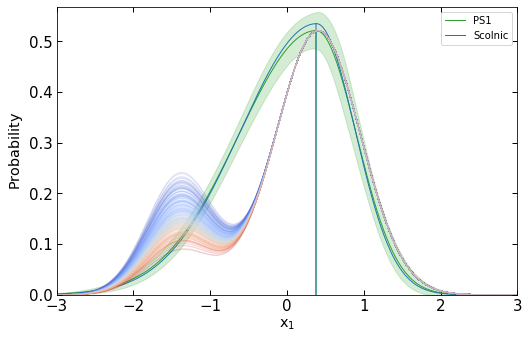

In [62]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymPS1.param['mu']

color_p = "C2"

pdf_PS1 = assymPS1.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymPS1.param['mu'],
                                  assymPS1.param['sigma_m'],
                                  assymPS1.param['sigma_p'])

ax.plot(x_linspace,
        pdf_PS1,
        color=color_p,
        lw=1, label='PS1')

ax.fill_between(x_linspace,
                pdf_PS1 + models_std_PS1,
                pdf_PS1 - models_std_PS1,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymPS1.param['mu'], ymin=0, ymax=np.max(pdf_PS1),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = param_sco[1][0]
sigma_m_s = param_sco[1][1]
sigma_p_s = param_sco[1][2]
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymPS1.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['PS1'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['PS1'].zCMB, [0,100])

for z in surv['PS1'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_PS1)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_PS1+models_std_PS1)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_PS1.pdf', bbox_inches='tight')

# SDSS

## Définition de _cov_ pour sélection aléatoire des paramètres

In [14]:
cov_SDSS = im.Minuit.matrix(assymSDSS.m_tot)
mean_SDSS = [assymSDSS.m_tot.values[i] for i in range(3)]
param_hesse_mat_SDSS = scipy.stats.multivariate_normal.rvs(mean=mean_SDSS, cov=cov_SDSS, size=500)

### List of all the models

In [15]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_SDSS = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_SDSS]
models_hesse_SDSS = np.asarray(models_hesse_SDSS)

### Take _std_

In [17]:
models_std_SDSS = np.std(models_hesse_SDSS, axis=0)

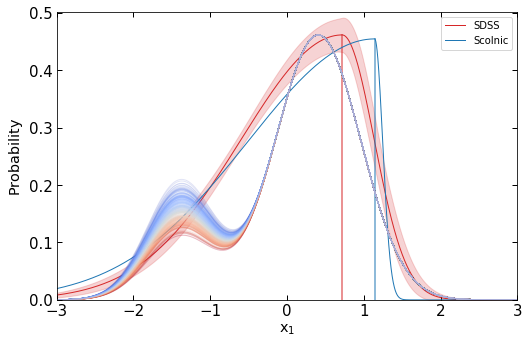

In [63]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymSDSS.param['mu']

color_p = "C3"

pdf_SDSS = assymSDSS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymSDSS.param['mu'],
                                  assymSDSS.param['sigma_m'],
                                  assymSDSS.param['sigma_p'])

ax.plot(x_linspace,
        pdf_SDSS,
        color=color_p,
        lw=1, label='SDSS')

ax.fill_between(x_linspace,
                pdf_SDSS + models_std_SDSS,
                pdf_SDSS - models_std_SDSS,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymSDSS.param['mu'], ymin=0, ymax=np.max(pdf_SDSS),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = param_sco[0][0]
sigma_m_s = param_sco[0][1]
sigma_p_s = param_sco[0][2]
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymSDSS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['SDSS'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['SDSS'].zCMB, [0,100])

for z in surv['SDSS'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_SDSS)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_SDSS+models_std_SDSS)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_SDSS.pdf', bbox_inches='tight')

# SNLS

## Définition de _cov_ pour sélection aléatoire des paramètres

In [20]:
cov_SNLS = im.Minuit.matrix(assymSNLS.m_tot)
mean_SNLS = [assymSNLS.m_tot.values[i] for i in range(3)]
param_hesse_mat_SNLS = scipy.stats.multivariate_normal.rvs(mean=mean_SNLS, cov=cov_SNLS, size=500)

### List of all the models

In [21]:
xlin = np.linspace(-3, 3, 3000)
models_hesse_SNLS = [assym_law_gen(xlin, param_hesse) for param_hesse in param_hesse_mat_SNLS]
models_hesse_SNLS = np.asarray(models_hesse_SNLS)

### Take _std_

In [22]:
models_std_SNLS = np.std(models_hesse_SNLS, axis=0)

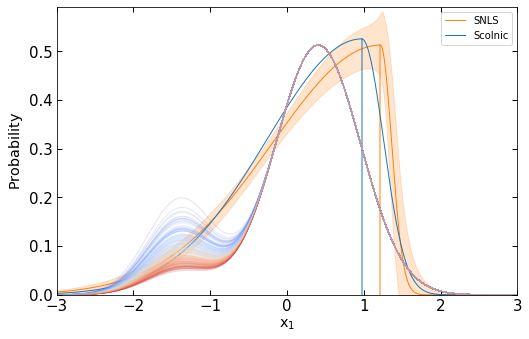

In [89]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(-3, 3, 3000)
flag_up = x_linspace >= assymSNLS.param['mu']

color_p = "C1"

pdf_SNLS = assymSNLS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  assymSNLS.param['mu'],
                                  assymSNLS.param['sigma_m'],
                                  assymSNLS.param['sigma_p'])

ax.plot(x_linspace,
        pdf_SNLS,
        color=color_p,
        lw=1, label='SNLS')

ax.fill_between(x_linspace,
                pdf_SNLS + models_std_SNLS,
                pdf_SNLS - models_std_SNLS,
                color=color_p,
                lw=1, alpha=.2)

ax.vline(assymSNLS.param['mu'], ymin=0, ymax=np.max(pdf_SNLS),
         color=color_p, alpha=.5, linewidth=2.0)

mu_s = param_sco[2][0]
sigma_m_s = param_sco[2][1]
sigma_p_s = param_sco[2][2]
flag_up_s = x_linspace >= mu_s

color_s = "C0"

pdf_SCO = assymSNLS.likelihood_tot(x_linspace,
                                  np.zeros(len(x_linspace)),
                                  mu_s,
                                  sigma_m_s,
                                  sigma_p_s)

ax.plot(x_linspace,
        pdf_SCO,
        color=color_s, label='Scolnic',
        lw=1)

ax.vline(mu_s, 0, np.max(pdf_SCO),
         color=color_s, alpha=.5, linewidth=2.0)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['SNLS'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['SNLS'].zCMB, [0,100])

for z in surv['SNLS'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            np.max(pdf_SNLS)/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.15,
            lw=1)
    i += 1
 
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([-3, 3])
ax.set_ylim([0, np.max(pdf_SNLS+models_std_SNLS)+0.01])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp_SNLS.pdf', bbox_inches='tight')

# Associated graph

In [177]:
with open('../Data/ALL_results', 'rb') as f:
    res_ALL = pickle.load(f)

def age_law_all(z):
    """Analytical law with 3G2M2S results"""
    return (delta(z)*res_ALL['mu_1']
      + (1-delta(z))*(base.get_a(res_ALL['aa'])*res_ALL['mu_1']
                      + (1 - base.get_a(res_ALL['aa']))*res_ALL['mu_2']))

with open('../Data/SNF_results', 'rb') as f:
    res_SNF = pickle.load(f)

def age_law_snf(z):
    """Analytical law with snf results"""
    return (delta(z)*res_SNF['mu_1'] +
        (1-delta(z))*(base.get_a(res_SNF['aa'])*res_SNF['mu_1']
                      + (1-base.get_a(res_SNF['aa']))*res_SNF['mu_2']))

def delta(z):
    return stretchevol.MockEvol().delta(z)

In [116]:
p_sco = {'SDSS': [1.142, 1.652, 0.104],
         'PS1': [0.384, 0.987, 0.505],
         'SNLS': [0.974, 1.236, 0.283]}

def pdfS(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSDSS.param['mu'],
                                    assymSDSS.param['sigma_m'],
                                    assymSDSS.param['sigma_p'])

def pdfP(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymPS1.param['mu'],
                                    assymPS1.param['sigma_m'],
                                    assymPS1.param['sigma_p'])

def pdfN(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    assymSNLS.param['mu'],
                                    assymSNLS.param['sigma_m'],
                                    assymSNLS.param['sigma_p'])

def pdfS_sco(x):
    return assymSDSS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SDSS'][0],
                                    p_sco['SDSS'][1],
                                    p_sco['SDSS'][2])

def pdfP_sco(x):
    return assymPS1.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['PS1'][0],
                                    p_sco['PS1'][1],
                                    p_sco['PS1'][2])

def pdfN_sco(x):
    return assymSNLS.likelihood_tot(x,
                                    np.zeros(len(x)),
                                    p_sco['SNLS'][0],
                                    p_sco['SNLS'][1],
                                    p_sco['SNLS'][2])

In [148]:
z_linspace = np.linspace(0, 1.4, 3000)
x_linspace = np.linspace(-10, 10, 1e7)

xmean_asymSDSS = np.sum(x_linspace*pdfS(x_linspace))/np.sum(pdfS(x_linspace))
xmean_asymPS1 = np.sum(x_linspace*pdfP(x_linspace))/np.sum(pdfP(x_linspace))
xmean_asymSNLS = np.sum(x_linspace*pdfN(x_linspace))/np.sum(pdfN(x_linspace))

xmean_asymSDSS_sco = np.sum(x_linspace*pdfS_sco(x_linspace))/np.sum(pdfS_sco(x_linspace))
xmean_asymPS1_sco = np.sum(x_linspace*pdfP_sco(x_linspace))/np.sum(pdfP_sco(x_linspace))
xmean_asymSNLS_sco = np.sum(x_linspace*pdfN_sco(x_linspace))/np.sum(pdfN_sco(x_linspace))

zlin_SDSS = np.linspace(np.percentile(df_full[df_full['survey'] == 'SDSS'].redshifts, [0, 100])[0],
                        np.percentile(df_full[df_full['survey'] == 'SDSS'].redshifts, [0, 100])[1],
                        2000)

zlin_PS1 = np.linspace(np.percentile(df_full[df_full['survey'] == 'PS1'].redshifts, [0, 100])[0],
                        np.percentile(df_full[df_full['survey'] == 'PS1'].redshifts, [0, 100])[1],
                        2000)

zlin_SNLS = np.linspace(np.percentile(df_full[df_full['survey'] == 'SNLS'].redshifts, [0, 100])[0],
                        np.percentile(df_full[df_full['survey'] == 'SNLS'].redshifts, [0, 100])[1],
                        2000)

fullz_SDSS = np.percentile(df[df['survey'] == 'SDSS'].redshifts, [0, 100])

fullz_PS1 = np.percentile(df[df['survey'] == 'PS1'].redshifts, [0, 100])

fullz_SNLS = np.percentile(df[df['survey'] == 'SNLS'].redshifts, [0, 100])

asz_SDSS = np.percentile(df[df['survey'] == 'SDSS'].redshifts, [5, 95])
asz_PS1 = np.percentile(df[df['survey'] == 'PS1'].redshifts, [5, 95])
asz_SNLS = np.percentile(df[df['survey'] == 'SNLS'].redshifts, [5, 95])

bsz_SDSS = np.percentile(df[df['survey'] == 'SDSS'].redshifts, [16, 84])
bsz_PS1 = np.percentile(df[df['survey'] == 'PS1'].redshifts, [16, 84])
bsz_SNLS = np.percentile(df[df['survey'] == 'SNLS'].redshifts, [16, 84])

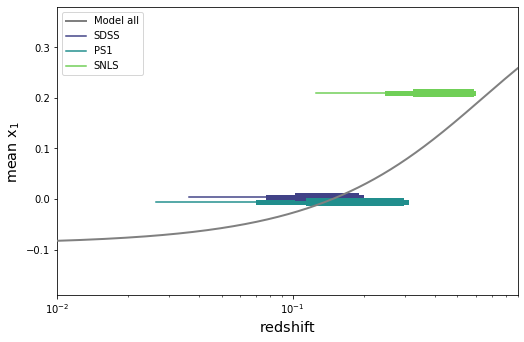

In [131]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.plot(z_linspace,
        age_law_all(z_linspace),
        color='0.5', lw=2, ls='-',
        label='Model all', zorder=6)

ax.plot(fullz_SDSS,
        [xmean_asymSDSS, xmean_asymSDSS],
        color=colors['SDSS'], label='SDSS')
ax.plot(fullz_PS1,
        [xmean_asymPS1, xmean_asymPS1],
        color=colors['PS1'], label='PS1')
ax.plot(fullz_SNLS,
        [xmean_asymSNLS, xmean_asymSNLS],
        color=colors['SNLS'], label='SNLS')

ax.plot(asz_SDSS,
        [xmean_asymSDSS, xmean_asymSDSS],
        color=colors['SDSS'], lw=5)
ax.plot(asz_PS1,
        [xmean_asymPS1, xmean_asymPS1],
        color=colors['PS1'], lw=5)
ax.plot(asz_SNLS,
        [xmean_asymSNLS, xmean_asymSNLS],
        color=colors['SNLS'], lw=5)

ax.plot(bsz_SDSS,
        [xmean_asymSDSS, xmean_asymSDSS],
        color=colors['SDSS'], lw=8)
ax.plot(bsz_PS1,
        [xmean_asymPS1, xmean_asymPS1],
        color=colors['PS1'], lw=8)
ax.plot(bsz_SNLS,
        [xmean_asymSNLS, xmean_asymSNLS],
        color=colors['SNLS'], lw=8)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.19, 0.38)
ax.set_xlim(0.01, 0.9)
ax.set_xscale('log')

ax.legend(ncol=1, loc='upper left')

fig.savefig('../../../Images/asym_BBC.pdf', bbox_inches='tight')

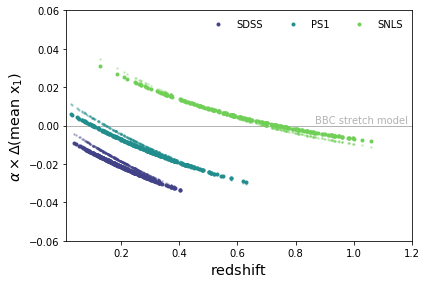

In [178]:
fig = plt.figure(figsize=[6, 4])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha = 0.154

ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
        alpha*(xmean_asymSDSS_sco - age_law_snf(df_full[df_full['survey'] == 'SDSS'].redshifts)),
        color=colors['SDSS'], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)

ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
        alpha*(xmean_asymPS1_sco - age_law_snf(df_full[df_full['survey'] == 'PS1'].redshifts)),
        color=colors['PS1'], lw=2, ls='None', marker='.', alpha=.3, ms=3, zorder=6)

ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
        alpha*(xmean_asymSNLS_sco - age_law_snf(df_full[df_full['survey'] == 'SNLS'].redshifts)),
        color=colors['SNLS'], lw=2, ls='None', marker='.', alpha=.3, ms=3,zorder=6)

ax.hline(0, zorder=2, color="0.7", lw=1)

ax.plot(df_full[df_full['survey'] == 'SDSS'].redshifts,
        alpha*(xmean_asymSDSS_sco - age_law_all(df_full[df_full['survey'] == 'SDSS'].redshifts)),
        color=colors['SDSS'], lw=2, ls='None', marker='.',
        label=r'SDSS', zorder=6)

ax.plot(df_full[df_full['survey'] == 'PS1'].redshifts,
        alpha*(xmean_asymPS1_sco - age_law_all(df_full[df_full['survey'] == 'PS1'].redshifts)),
        color=colors['PS1'], lw=2, ls='None', marker='.',
        label=r'PS1', zorder=6)

ax.plot(df_full[df_full['survey'] == 'SNLS'].redshifts,
        alpha*(xmean_asymSNLS_sco - age_law_all(df_full[df_full['survey'] == 'SNLS'].redshifts)),
        color=colors['SNLS'], lw=2, ls='None', marker='.',
        label=r'SNLS', zorder=6)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\alpha\times\Delta\left(\mathrm{mean\,\,x}_1\right)$ ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.06, 0.06)
ax.set_xlim(0.01, 1.2)
#ax.set_xscale('log')

ax.legend(ncol=3, loc='upper right', frameon=False)

ax.text(0.99, 0.5, 'BBC stretch model',
        va='bottom', ha='right', transform=ax.transAxes,
        color='0.7')

fig.savefig('../../../Images/BBC_-stretchevol.pdf', bbox_inches='tight')

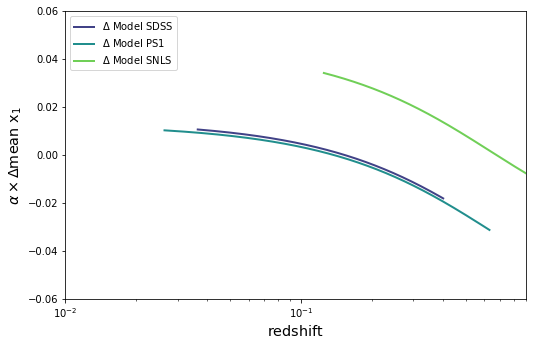

In [161]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha = 0.154

ax.plot(zlin_SDSS,
        alpha*(xmean_asymSDSS - age_law_snf(zlin_SDSS)),
        color=colors['SDSS'], lw=2, ls='-',
        label=r'$\Delta$ Model SDSS', zorder=6)

ax.plot(zlin_PS1,
        alpha*(xmean_asymPS1 - age_law_snf(zlin_PS1)),
        color=colors['PS1'], lw=2, ls='-',
        label=r'$\Delta$ Model PS1', zorder=6)

ax.plot(zlin_SNLS,
        alpha*(xmean_asymSNLS - age_law_snf(zlin_SNLS)),
        color=colors['SNLS'], lw=2, ls='-',
        label=r'$\Delta$ Model SNLS', zorder=6)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\alpha\times\Delta\mathrm{mean\,\,x}_1$ ", fontsize="x-large")

#ax.set_ylim(-0.52, 0.52)
ax.set_ylim(-0.06, 0.06)
ax.set_xlim(0.01, 0.9)
ax.set_xscale('log')

ax.legend(ncol=1, loc='upper left')

fig.savefig('../../../Images/US_-stretchevol.pdf', bbox_inches='tight')

## Get proba

In [11]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

In [48]:
modèles = [assymSDSS, assymPS1, assymSNLS, assymSNF]

assym_comp = pd.DataFrame({'Assym': ['SDSS', 'PS1', 'SNLS', 'SNf', 'Total'],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles] + [np.sum([len(k.FREEPARAMETERS) for k in modèles])],
                           '$\sigma^-$': [round(k.migrad_out[1][1][2],2) for k in modèles] + ['--'],
                           '$\sigma^-_{\mathrm{err}}$': [round(k.migrad_out[1][1][3],2) for k in modèles] + ['--'],
                           '$\sigma^+$': [round(k.migrad_out[1][2][2],2) for k in modèles] + ['--'],
                           '$\sigma^+_{\mathrm{err}}$': [round(k.migrad_out[1][2][3],2) for k in modèles] + ['--'],
                           '$\mu^0$': [round(k.migrad_out[1][0][2],2) for k in modèles] + ['--'],
                           '$\mu^0_{\mathrm{err}}$': [round(k.migrad_out[1][0][3],2) for k in modèles] + ['--'],
                           '$\mathcal{L}$': [round(k.get_logl(),1) for k in modèles] + [round(np.sum([k.get_logl() for k in modèles]),1)],
                           'AICc': [round(k.get_aicc(),1) for k in modèles] + [round(np.sum([k.get_aicc() for k in modèles]),1)]})

path = '../Data/assym_comp'
if cons.value:
    path += '_cons'
path += '.dat'
assym_comp.to_csv(path)

assym_comp

,Assym,Free param,$\sigma^-$,$\sigma^-_{\mathrm{err}}$,$\sigma^+$,$\sigma^+_{\mathrm{err}}$,$\mu^0$,$\mu^0_{\mathrm{err}}$,$\mathcal{L}$,AICc
0,SDSS,3,1.31,0.11,0.42,0.09,0.72,0.13,445.0,451.2
1,PS1,3,1.01,0.11,-0.52,0.12,0.38,0.16,397.4,403.6
2,SNLS,3,1.41,0.13,0.15,0.13,1.22,0.15,252.7,259.0
3,SNf,3,1.34,0.13,-0.41,0.1,0.68,0.15,299.3,305.5
4,Total,12,--,--,--,--,--,--,1394.5,1419.2


## Minimisation du modèle SNF et calcul $\mathcal{L}$ pour surveys

In [17]:
gen.set_model('Evol3G2M2S')
gen.set_data(df[df['survey'] == 'SDSS'])
baseSDSS = gen.fit()

gen.set_data(df[df['survey'] == 'PS1'])
basePS1 = gen.fit()

gen.set_data(df[df['survey'] == 'SNLS'])
baseSNLS = gen.fit()

In [18]:
models = [basePS1, baseSDSS, baseSNLS]

snf_comp = pd.DataFrame({'Base': ['SDSS', 'PS1', 'SNLS', 'Total'],
                         'Free param': [0 for k in models] + [0],
                         '$\mathcal{L}$': [round(k.get_logl(),1) for k in models] + [round(np.sum([k.get_logl() for k in models]),1)],
                         'AICc': [round(k.get_aicc(),1) for k in models] + [round(np.sum([k.get_aicc() for k in models]),1)]})

path = '../Data/snf_comp'
if cons.value:
    path += '_cons'
path += '.dat'
snf_comp.to_csv(path)

snf_comp

,Base,Free param,ln $\mathcal{L}$,AICc
0,SDSS,0,395.2,405.6
1,PS1,0,444.7,455.0
2,SNLS,0,254.1,264.7
3,Total,0,1094.0,1125.4
